In [1]:
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

from functions import get_recommendations


In [2]:
materials = pd.read_csv('../datasets/clean_data/materials_clean.csv')
fab_requests = pd.read_csv('../datasets/clean_data/fabric_requests_clean.csv')
cosine_sims_X1 = pd.read_csv('../datasets/clean_data/materials_cosine_sim.csv')

In [3]:
# Ignoring warnings because there are some warnings related to SettingWithCopyWarning 
# inspite of using the correct code (.loc[row_indexer,col_indexer] = value)

warnings.simplefilter('ignore') 

# Feature Engineering and Feature selection

In [4]:
materials.shape

(1539, 43)

In [5]:
fab_requests.isnull().sum()

id                       0
status                   0
type                     0
quantity                 0
material_id              0
user_id                  0
user_email               0
user_name                0
user_activation_state    0
user_role                0
material_name            0
dtype: int64

#### Assign higher weightage to Sample requests

Sample requests are more deliberate and indicative of interest than Swatch requests we will assign higher weighage to sample requests by doubling the quantity of the sample requests. 

In [6]:
fab_requests_reco = fab_requests.copy()
fab_requests_reco["fab_req_weight"] = fab_requests_reco["type"].map({"swatch": 1, "sample": 2})


#### Club together fabric requests made by same user for same materials

In [7]:
fab_requests_reco = pd.DataFrame(fab_requests_reco.groupby(by=["user_id", "user_email", "material_id", "material_name"])["fab_req_weight"].sum())
fab_requests_reco

fab_req_weight
user_id user_email              material_id material_name                                            
36      XXXXXXXa@XXXXXr.com     854         XXXXXXXXXXtin Light weight Fabric                       1
                                856         XXXXXXXXXXnen blended Light weight fabric               1
                                1172        XXXXXXXXXXuard Upcycled Silk (76000TP)                  1
                                1173        XXXXXXXXXXuard Upcycled Silk (76000DP)                  1
                                1178        XXXXXXXXXXuard Upcycled Silk (76007SP)                  1
...                                                                                               ...
574     XXXXXXXXXXXXg.com       2076        XXXXXXXXXXtton Fleece                                   1
                                2077        XXXXXXXXXXtton Jersey                                   1
                                2531        XXXXXXXXXX Canvas Lyocell/Linen 290 gsm                 1
582     XXXXXXX@XXXXXdipiume.it 2336        XXXXXXXXXX Sample Box                                   7
587     XXXXXXX@XXXXXdigital    2532        XXXXXXXXXX Canvas Recycled Cotton 400 gsm               1

[549 rows x 1 columns]

In [8]:
fab_requests_reco = fab_requests_reco.reset_index()

#### Left join the materials table and the fab_requests_reco tables, so that materials which don't have fabric requests can be included in the dataset, with null values for fabric request fields.

In [9]:
materials_fab_req = materials.merge(fab_requests_reco, how="left", left_on="id", right_on="material_id")


In [10]:
materials_fab_req

,id,created_at,updated_at,code,fabric_weave,currency,supplier_id,price,name,fabric_blend_one,...,supp_name,supp_fabric_type,supp_specialty,supp_end_uses,supp_fibers,user_id,user_email,material_id,material_name,fab_req_weight
0,2253,2021-04-13 14:32:14.096000+00:00,2021-07-28 08:59:59.993000+00:00,C201069,Ripstop,EUR,23,11.90,XXXXXXXXXXganic Cotton,Organic Cotton,...,XXXXXXXXXX,TECHNICAL AND OUTWEAR FABRICS,blank_specialty,MEDIUM HIGH LUXURY BRANDS,"Cotton, Polyamide (Nylon) ,Polyester, Wool, SE,LI",168.0,XXXXXXXhaylovast@XXXXX.com,2253.0,XXXXXXXXXXganic Cotton,1.0
1,557,2020-01-30 10:24:36.482000+00:00,2021-06-18 04:11:19.866000+00:00,Checkered Stripes,blank_weave,USD,25,13.52,XXXXXXXXXXStripes TENCEL,TENCEL Lyocell,...,XXXXXXXXXX,blank_fabrictype,"Wovens, small order",blank_end_uses,blank_fibers,106.0,XXXXXXXinezadesign@XXXXX.com,557.0,XXXXXXXXXXStripes TENCEL,1.0
2,947,2020-06-04 14:11:02.191000+00:00,2021-05-11 12:31:46.481000+00:00,Low MOQ Sr 11,Plain,USD,27,1.80,XXXXXXXXXXtton (40sx40s/136x70),Organic Cotton,...,XXXXXXXXXXics,Woven and Knits,blank_specialty,"Mens Wear, Women's wear, OOTD",Organic natural fibres,NaN,NaN,NaN,NaN,NaN
3,2276,2021-04-30 09:47:50.602000+00:00,2021-07-29 15:00:06.378000+00:00,CIAO/ORG,Terry,EUR,44,15.90,XXXXXXXXXXerry Organic Cotton,Organic Cotton,...,XXXXXXXXXX,Knit,Recycled Natural Fibre,blank_end_uses,"Recycled Wool, Recycled Cotton",NaN,NaN,NaN,NaN,NaN
4,1840,2020-12-09 15:16:21.547000+00:00,2021-06-19 04:39:06.515000+00:00,#0014BK11B0000,blank_weave,USD,67,32.00,XXXXXXXXXX0000,Recycled Cow Leather,...,XXXXXXXXXXher,Others,Sustainable Leather,"Accessories, Leather Goods, Luxury, New Innova...",Leather / Skin,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1719,1388,2020-07-26 21:49:34.702000+00:00,2021-07-27 14:40:54.467000+00:00,ORGANIC PIRARUCU PANEL LL SEMI SHINY BLACK,blank_weave,EUR,54,170.00,XXXXXXXXXXRARUCU PANEL LL SEMI SHINY BLACK,Pirarucu (fish skin),...,XXXXXXXXXXu,Leather / Plant leaf,Sustainable Leather,Garments/ Accessories/ Upholst,blank_fibers,NaN,NaN,NaN,NaN,NaN
1720,1376,2020-07-26 21:49:34.532000+00:00,2021-07-27 14:40:54.480000+00:00,ORGANIC PIRARUCU WILD LL SEMI-MATTE ROCCIA,blank_weave,EUR,54,252.00,XXXXXXXXXXRARUCU WILD LL SEMI-MATTE ROCCIA,Pirarucu (fish skin),...,XXXXXXXXXXu,Leather / Plant leaf,Sustainable Leather,Garments/ Accessories/ Upholst,blank_fibers,NaN,NaN,NaN,NaN,NaN
1721,1882,2020-12-09 20:39:06.084000+00:00,2021-06-19 05:19:36.595000+00:00,RONT 3171-PU,Plain,USD,68,10.30,XXXXXXXXXXcled Nylon,Recycled Nylon,...,XXXXXXXXXX,Woven,Post consumer recycled synthetics,Outerwear,Recycled Synthetics,NaN,NaN,NaN,NaN,NaN
1722,2011,2021-02-09 21:46:36.323000+00:00,2021-06-19 05:19:37.426000+00:00,RORE 3722-BL,Plain,USD,68,3.50,XXXXXXXXXXcled Polyester,Recycled Polyester,...,XXXXXXXXXX,Woven,Post consumer recycled synthetics,Outerwear,Recycled Synthetics,455.0,XXXXXXXXXXXXolechat.com,2011.0,XXXXXXXXXXcled Polyester,1.0


In [11]:
materials_fab_req["user_id"] = materials_fab_req["user_id"].fillna(0)
materials_fab_req["fab_req_weight"] = materials_fab_req["fab_req_weight"].fillna(0)

#### Build a piviot table from the materials fabric requests dataset. Rows are material ids, columns are user ids and intersections are fabric request weight i.e. no of fabric requests weighted by sample or swatch types. 

In [12]:
fab_requests_pivot = materials_fab_req.pivot_table(index="id", columns="user_id", values="fab_req_weight").fillna(0)

In [13]:
fab_requests_pivot[630:]

user_id,0.0,36.0,44.0,58.0,87.0,101.0,106.0,114.0,151.0,168.0,...,497.0,532.0,533.0,534.0,541.0,551.0,567.0,574.0,582.0,587.0
id,,,,,,,,,,,,,,,,,,,,,
1172,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1173,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2530,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2531,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2532,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [14]:
# Get compressed sparse matrix to pass to the nearest neighbour algorithm
fab_requests_matrix = csr_matrix(fab_requests_pivot)
type(fab_requests_matrix)

scipy.sparse.csr.csr_matrix

#### Use nearest neighbours unsupervised method to find the nearest materials matching based on user requests

In [15]:
knn = NearestNeighbors(metric="cosine", algorithm="brute", n_neighbors=10)
knn.fit(fab_requests_matrix)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=10)

In [16]:
# Find for recommendations for specific materials
query_index = np.random.choice(fab_requests_matrix.shape[0])

distances, indices = knn.kneighbors(X=fab_requests_pivot.iloc[query_index, :].values.reshape(1, -1), n_neighbors=10)

# Item based Collaborative Filtering using Fabric Requests

Collaborative filtering filters information by using the interactions and data collected by the system from other users. We use Item Based collaborative filtering which measures the similarity between the items that the users rate or interact with and other items. Since Fabric Central deosn't have user clicks or ratings data, our system will find similar materials based on the fabric requests made by users.

In [17]:
def get_user_based_recommendations(knn_model, full_dataset, pivot_table, name="", mat_id=0, n=10):
    reco_list = []
    orig_material = []

    # If material name is passed find the material id first
    if(name != ""):
        mat_id = full_dataset[full_dataset["name"] == name].drop_duplicates()["material_id"]

    # Find the n+1 nearest neighbours of the given material id (1st one is the material itself)
    distances, indices = knn_model.kneighbors(X=pivot_table.loc[mat_id, :].values.reshape(1, -1), n_neighbors=n+1)

    # Loop through the returned materials and append the material ids and distances in a list
    for i in range(0, len(distances.flatten())):
        rec_id = pivot_table.index[indices.flatten()[i]]
        rec_distance = float(distances.flatten()[i])

        if ((rec_distance < 0.5) & (i != 0)):
            reco_list.append(rec_id)
        elif (i==0):
            orig_material.append(rec_id)

    return full_dataset.loc[full_dataset["id"].isin(reco_list)], full_dataset.loc[full_dataset["id"].isin(orig_material)]


In [18]:
results, orig = get_user_based_recommendations(knn, materials, fab_requests_pivot, name="", mat_id=489)
orig.loc[:, ['id','name', 'fabric_blend_one', 'price', 'weight', 'supplier_id', 'end_use', 'properties']]

,id,name,fabric_blend_one,price,weight,supplier_id,end_use,properties
82,489,XXXXXXXXXXnic Cotton Recycled Polyester,Organic Cotton,11.2,205.0,23,"['Jacket', 'Coat']",['Water Repellent (W/R)']


In [19]:
results.loc[:, ['id','name', 'fabric_blend_one', 'price', 'weight', 'supplier_id', 'end_use', 'properties']]

,id,name,fabric_blend_one,price,weight,supplier_id,end_use,properties
90,650,XXXXXXXXXXodegradable Nylon,Biodegradable Nylon,17.50,260.0,23,"['Coat', 'Softshell Jacket', 'Jacket', 'Trench...",['Water Repellent (W/R)']
141,2269,XXXXXXXXXXolyester PU,Recycled Polyester,16.55,120.0,23,"['Softshell Jacket', 'Jacket']",[]
216,381,XXXXXXXXXXbrane Plain Polyester,Polyester (PET),5.95,106.0,18,[],['Durable Water Repellent (DWR)']
469,2265,XXXXXXXXXX Glass Polyester,Glass,24.45,420.0,23,"['Coat', 'Jacket']",['Reflective']
563,656,XXXXXXXXXXcled Polyester,Recycled Polyester,9.80,280.0,23,"['Coat', 'Jacket', 'Softshell Jacket']",['Water Repellent (W/R)']
649,495,XXXXXXXXXXcled Nylon 1,Recycled Nylon,13.90,80.0,23,"['Jacket', 'Softshell Jacket']",['Water Repellent (W/R)']
1028,496,XXXXXXXXXXcled Polyester PU,Recycled Polyester,15.90,135.0,23,"['Jacket', 'Softshell Jacket']","['Water Repellent (W/R)', 'Waterproof (W/P)', ..."
1290,1236,XXXXXXXXXXsey,Hemp,23.40,190.0,43,"['Base Layer', 'Sweatshirt', 'T-Shirt']",[]
1472,662,XXXXXXXXXXlain Nylon,Recycled Nylon,9.95,110.0,23,"['Jacket', 'Swimming Shorts']",['Water Repellent (W/R)']
1509,1798,XXXXXXXXXX Hemp,Wool,66.00,370.0,57,"['Jacket', 'Pants', 'Shirt']",['Breathable']


In [20]:
mat_arr = materials_fab_req[materials_fab_req["material_id"].notnull()]["id"].unique()

no_rec = 0
few_rec = 0
five_rec = 0
for i in range(len(mat_arr)):
    results, orig = get_user_based_recommendations(knn, materials, fab_requests_pivot, name="", mat_id=mat_arr[i])
    if (len(results) == 10):
        five_rec += 1
    elif (len(results) < 10) & (len(results) > 0):
        few_rec += 1
    elif (len(results) == 0):
        no_rec += 1

print(f"{no_rec} materials had no recommendations, {few_rec} had less than 10 recommendations, {five_rec} had 10 recommendations")


11 materials had no recommendations, 114 had less than 10 recommendations, 239 had 10 recommendations


Many of the materials don't have fabric requests associated with them. This is a cold start problem. Until more fabric requests are gathered we can use Hybrid recommendations, which are a combination of item based collaborative filtering and content based filtering. 

# Hybrid Recommendations

In [21]:
def get_hybrid_recommendations_list(full_dataset, similarity_matrix, knn_model, pivot_table, name="", mat_id=0, url_stub="", reco_count=10):
    
    # Get user based recommendations which will return the results in two datasets results and orig
    results1, orig1 = get_user_based_recommendations(knn_model, full_dataset, pivot_table, name=name, mat_id=mat_id, n=reco_count)
    usr_reco_count = len(results1)

    if(usr_reco_count < reco_count):
        ib_reco_count = reco_count - len(results1)

        # Call Get recommendations which will return the resuls in two datasets resulst and orig
        results2, orig2 = get_recommendations(full_dataset, similarity_matrix, name, mat_id=mat_id, n=ib_reco_count, user_based_results=results1)
        results1 = pd.concat([results1, results2], axis=0)
    else:
        ib_reco_count = 0
    
    # Add columns to the results dataset to make the results as per requirement for exporting to csv
    results1["recommendation_str"] = results1.apply(lambda x: f'=HYPERLINK("#" &CELL("address",INDEX(A2:A1540,MATCH({x["id"]},A2:A1540,0))), "{x["id"]}, {x["name"]}")', axis=1)

    #return the results as a dataseries of lists
    return [usr_reco_count, ib_reco_count, results1["recommendation_str"].tolist()]


In [22]:
def get_hybrid_recommendations_for_all(full_dataset, similarity_matrix, knn_model, pivot_table, url_stub="", reco_count=10):
    
    # Create a copy of the full dataset,
    # this is where the list of recommendations will be appended as a column
    full_ds_copy = full_dataset.copy()
     
    # Call the get_hybrid_recommendations_list for all rows of the full dataset,
    # pass the reco_dataset and fab_req_reco_dataset which contains only the relevant features
    lst_return_columns = full_ds_copy.apply(lambda x: get_hybrid_recommendations_list(full_dataset, similarity_matrix, knn_model, pivot_table, mat_id=x["id"], url_stub=url_stub), axis=1)
           
    # Convert the list fo recommendations to separate columns, to enable to view easily
    df_recommendations = pd.DataFrame([i[2] for i in lst_return_columns],
                                      index=full_ds_copy.index, columns=["recommendation_1",
                "recommendation_2", "recommendation_3", "recommendation_4",
                "recommendation_5", "recommendation_6", "recommendation_7",
                "recommendation_8", "recommendation_9", "recommendation_10"])
    
    df_recommendations["usr_reco_count"] = [i[0] for i in lst_return_columns]
    df_recommendations["itm_reco_count"] = [i[1] for i in lst_return_columns]

    # Add the columns to the copy of the full dataset
    full_ds_copy = pd.concat([full_ds_copy, df_recommendations], axis=1)

    return full_ds_copy

In [23]:
# Set the index of the cosine similarity matrix which was read from the csv file
# Convert to integer index as it is being created as a string
cosine_sims_X1.index = cosine_sims_X1["id"]
cosine_sims_X1.index = pd.to_numeric(cosine_sims_X1.index, errors='coerce')

#Drop the id column as it is now the index
cosine_sims_X1.drop(columns=["id"], inplace=True)
cosine_sims_X1.index

Int64Index([2253,  557,  947, 2276, 1840, 1814, 1924, 1255,  217, 2488,
            ...
             927, 2021, 1395, 1371, 1360, 1388, 1376, 1882, 2011, 1896],
           dtype='int64', name='id', length=1539)

In [24]:
cosine_sims_X1.head()

,2253,557,947,2276,1840,1814,1924,1255,217,2488,...,927,2021,1395,1371,1360,1388,1376,1882,2011,1896
id,,,,,,,,,,,,,,,,,,,,,
2253,1.000000,0.198305,0.266200,0.190446,0.056001,0.131389,0.173102,0.007311,0.008437,0.300367,...,0.374091,0.429161,0.328324,0.301587,0.301587,0.308967,0.301587,0.302940,0.299414,0.319486
557,0.198305,1.000000,0.000056,0.000512,0.001306,0.000453,0.000593,0.547233,0.000074,0.298142,...,0.181928,0.282153,0.312018,0.305657,0.305657,0.312820,0.305657,0.297842,0.298002,0.315889
947,0.266200,0.000056,1.000000,0.228343,0.030986,0.001908,0.003160,0.003965,0.004715,0.194693,...,0.709279,0.368829,0.011678,0.000824,0.000824,0.000573,0.000824,0.196124,0.194251,0.207082
2276,0.190446,0.000512,0.228343,1.000000,0.069700,0.004570,0.007452,0.160672,0.010513,0.006920,...,0.169214,0.130274,0.028909,0.007487,0.007487,0.005204,0.007487,0.010475,0.005648,0.008627
1840,0.056001,0.001306,0.030986,0.069700,1.000000,0.010028,0.016293,0.019719,0.022686,0.015036,...,0.039361,0.173404,0.381298,0.326305,0.326305,0.330243,0.326305,0.022689,0.012205,0.018635


We get Hybrid recommendations for all materials and save as a csv file which will be shared with a domain expert for evaluation

In [25]:
materials_hyb_reco = get_hybrid_recommendations_for_all(materials, cosine_sims_X1, knn, fab_requests_pivot, reco_count=10)


In [26]:
materials_hyb_reco.head()

,id,created_at,updated_at,code,fabric_weave,currency,supplier_id,price,name,fabric_blend_one,...,recommendation_3,recommendation_4,recommendation_5,recommendation_6,recommendation_7,recommendation_8,recommendation_9,recommendation_10,usr_reco_count,itm_reco_count
0,2253,2021-04-13 14:32:14.096000+00:00,2021-07-28 08:59:59.993000+00:00,C201069,Ripstop,EUR,23,11.90,XXXXXXXXXXganic Cotton,Organic Cotton,...,"=HYPERLINK(""#"" &CELL(""address"",INDEX(A2:A1540,...","=HYPERLINK(""#"" &CELL(""address"",INDEX(A2:A1540,...","=HYPERLINK(""#"" &CELL(""address"",INDEX(A2:A1540,...","=HYPERLINK(""#"" &CELL(""address"",INDEX(A2:A1540,...","=HYPERLINK(""#"" &CELL(""address"",INDEX(A2:A1540,...","=HYPERLINK(""#"" &CELL(""address"",INDEX(A2:A1540,...","=HYPERLINK(""#"" &CELL(""address"",INDEX(A2:A1540,...","=HYPERLINK(""#"" &CELL(""address"",INDEX(A2:A1540,...",10,0
1,557,2020-01-30 10:24:36.482000+00:00,2021-06-18 04:11:19.866000+00:00,Checkered Stripes,blank_weave,USD,25,13.52,XXXXXXXXXXStripes TENCEL,TENCEL Lyocell,...,"=HYPERLINK(""#"" &CELL(""address"",INDEX(A2:A1540,...","=HYPERLINK(""#"" &CELL(""address"",INDEX(A2:A1540,...","=HYPERLINK(""#"" &CELL(""address"",INDEX(A2:A1540,...","=HYPERLINK(""#"" &CELL(""address"",INDEX(A2:A1540,...","=HYPERLINK(""#"" &CELL(""address"",INDEX(A2:A1540,...","=HYPERLINK(""#"" &CELL(""address"",INDEX(A2:A1540,...","=HYPERLINK(""#"" &CELL(""address"",INDEX(A2:A1540,...","=HYPERLINK(""#"" &CELL(""address"",INDEX(A2:A1540,...",10,0
2,947,2020-06-04 14:11:02.191000+00:00,2021-05-11 12:31:46.481000+00:00,Low MOQ Sr 11,Plain,USD,27,1.80,XXXXXXXXXXtton (40sx40s/136x70),Organic Cotton,...,"=HYPERLINK(""#"" &CELL(""address"",INDEX(A2:A1540,...","=HYPERLINK(""#"" &CELL(""address"",INDEX(A2:A1540,...","=HYPERLINK(""#"" &CELL(""address"",INDEX(A2:A1540,...","=HYPERLINK(""#"" &CELL(""address"",INDEX(A2:A1540,...","=HYPERLINK(""#"" &CELL(""address"",INDEX(A2:A1540,...","=HYPERLINK(""#"" &CELL(""address"",INDEX(A2:A1540,...","=HYPERLINK(""#"" &CELL(""address"",INDEX(A2:A1540,...","=HYPERLINK(""#"" &CELL(""address"",INDEX(A2:A1540,...",0,10
3,2276,2021-04-30 09:47:50.602000+00:00,2021-07-29 15:00:06.378000+00:00,CIAO/ORG,Terry,EUR,44,15.90,XXXXXXXXXXerry Organic Cotton,Organic Cotton,...,"=HYPERLINK(""#"" &CELL(""address"",INDEX(A2:A1540,...","=HYPERLINK(""#"" &CELL(""address"",INDEX(A2:A1540,...","=HYPERLINK(""#"" &CELL(""address"",INDEX(A2:A1540,...","=HYPERLINK(""#"" &CELL(""address"",INDEX(A2:A1540,...","=HYPERLINK(""#"" &CELL(""address"",INDEX(A2:A1540,...","=HYPERLINK(""#"" &CELL(""address"",INDEX(A2:A1540,...","=HYPERLINK(""#"" &CELL(""address"",INDEX(A2:A1540,...","=HYPERLINK(""#"" &CELL(""address"",INDEX(A2:A1540,...",0,10
4,1840,2020-12-09 15:16:21.547000+00:00,2021-06-19 04:39:06.515000+00:00,#0014BK11B0000,blank_weave,USD,67,32.00,XXXXXXXXXX0000,Recycled Cow Leather,...,"=HYPERLINK(""#"" &CELL(""address"",INDEX(A2:A1540,...","=HYPERLINK(""#"" &CELL(""address"",INDEX(A2:A1540,...","=HYPERLINK(""#"" &CELL(""address"",INDEX(A2:A1540,...","=HYPERLINK(""#"" &CELL(""address"",INDEX(A2:A1540,...","=HYPERLINK(""#"" &CELL(""address"",INDEX(A2:A1540,...","=HYPERLINK(""#"" &CELL(""address"",INDEX(A2:A1540,...","=HYPERLINK(""#"" &CELL(""address"",INDEX(A2:A1540,...","=HYPERLINK(""#"" &CELL(""address"",INDEX(A2:A1540,...",0,10


In [27]:
materials_hyb_reco.shape

(1539, 55)

Text(0, 0.5, 'Material Count')

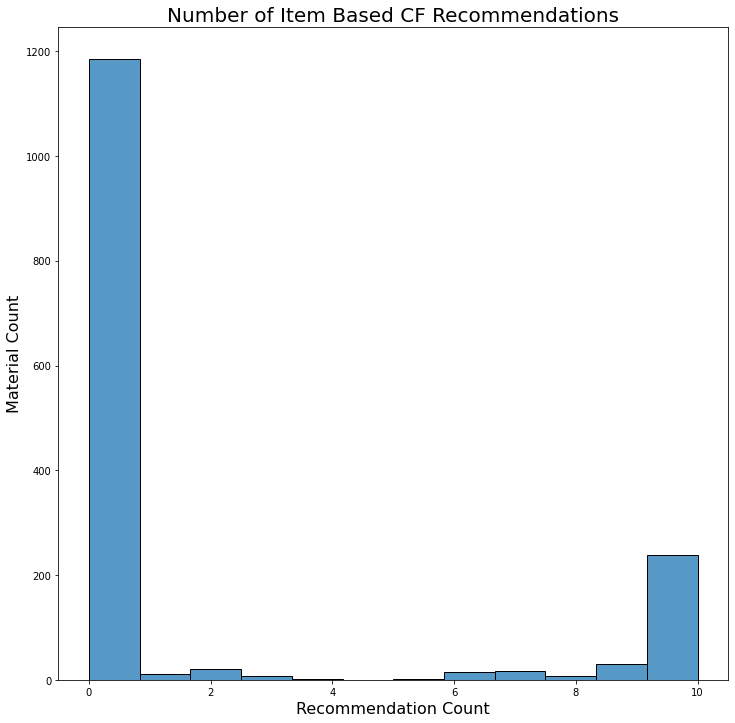

In [28]:
plt.figure(figsize=(12,12))
bp = sns.histplot(data=materials_hyb_reco, x="usr_reco_count")
bp.set_title("Number of Item Based CF Recommendations", fontsize=20)
bp.set_xlabel("Recommendation Count", fontsize=16)
bp.set_ylabel("Material Count", fontsize=16)





We can see that most materiats have 0 count of recommendations because of Collaborative filtering, also a few of them have less than 10 recommendations. As more fabric requests are generated we will find that the hybrid filtering will move more towards collaborative filtering. 

In [29]:
# Save the recommendations to csv
materials_hyb_reco[["id","name", "fabric_blend_one", "price", "weight", 
              "supplier_id", "end_use", "properties", "usr_reco_count", "itm_reco_count", "recommendation_1", 
                "recommendation_2", "recommendation_3", "recommendation_4",
                "recommendation_5", "recommendation_6", "recommendation_7", 
                "recommendation_8", "recommendation_9", "recommendation_10"]].to_csv("../recommendations/material_Hybrid_recommendations.csv", index=False)


## Evaluation

- Evaluation using domain Knowledge<br>
    - Recommendation systems with unlabelled data are difficult to evaluate before they are deployed. In this case we used the domain knowledge of experts to assess the recommendations made by our system.  Recommendations (both Content Based and Collaborative) for all materials in the database were outputted to csv files. These were made user friendly for the users by providing hyperlinks in the file to enable them to click on the recommended materials and view the features of the recommended materials. 

- After the system is deployed we can use following methods for evaluation:<br>
    - Tracking User clicks<br>
    Tracking user clicks from specific web pages to measure metrics such as Click - Through Rate, Conversion Rate etc.
    - A/B testing<br>
    Comparing recommendations from various methods by using A/B testing.

# Conclusion & Recommendations

Recommendation Systems have been many benefits such as improving customer engagement, customer conversion rate and in turn the revenue of ecommece websites. Our project find that both Content Based (CB) and item based Collaborative Filtering (CF)is possible using the existing data that Fabric Central has. Initial evaluation by domain experts, shows accurate recommendations for both CB and CF FIltering. 

The actual performance of the recommendation system can evaluated after it is deployed on the website. In conclusion the recommendation system can be integrated and deployed on the website, to help improve the customer satisfaction as well as sales for Fabric Central. 

#### Where should the recommendations be displayed?

- Content Based Materials should be displayed on Material Search page

- Hybrid Recommendations should be displayed on the materials details page

- Optionally, Collaborative Filtering recommendations should be displayed on Order Completion page

#### Other Recommendations 
1. User clicks from recommendations, should be tracked upon deployment of the recommendation system. This can help to evaluate the percentange of users that are clicking on the recommended materials. 

2. A/B testing should be performed to compare user behaviour with the various recommendation methods. 

3. Implement explicit user feedback such as reviews/ratings should be implemented for materials, to get more accurate recommendations for users. 

4. More user attributes should be gathered when signing up users. This will enable us to implement user based collaborative filtering. 


# Future Steps

- Integration & Deployment of the recommendation system to integrate with existing web application

- User Based Collaborative Filtering, based on similarity of user attributes

- Explore other algorithms for item based collaborative filtering like Matrix Factorization, Deep Learning

- Implement A/B testing to assess relative performance of various models